# Causal Inference on Diabetes Diagnosis and HbA1c (NHANES)

In [6]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("NHANES_Cleaned_Diabetes_Causal.csv")
df.head()


,SEQN,Gender,Age,Race,Education,Income_Poverty_Ratio,Diabetes,HbA1c
0,93705.0,Female,66.0,Non-Hispanic Black,9–11th grade,0.82,0.0,6.2
1,93708.0,Female,66.0,Other Race - Including Multi-Racial,<9th grade,1.63,3.0,6.2
2,93709.0,Female,75.0,Non-Hispanic Black,Some college/AA degree,0.41,0.0,6.3
3,93711.0,Male,56.0,Other Race - Including Multi-Racial,College graduate or above,5.00,0.0,5.7
4,93713.0,Male,67.0,Non-Hispanic White,High school/GED,2.65,0.0,5.6


## Exploratory Data Analysis

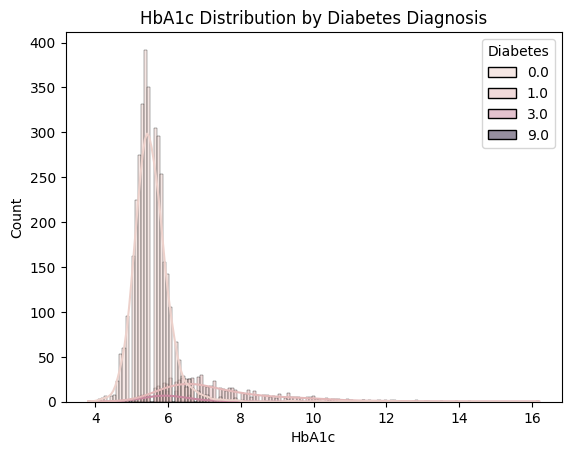

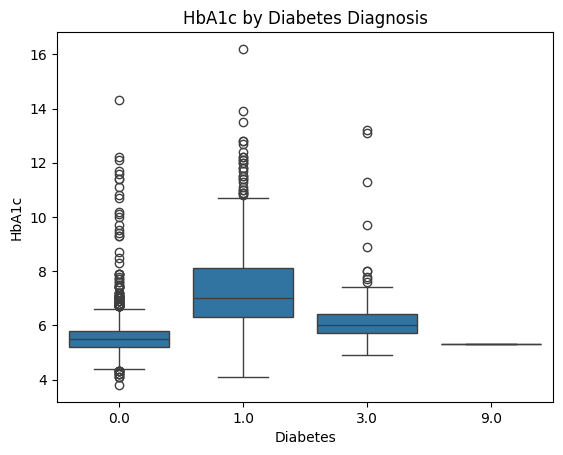

In [2]:

sns.histplot(data=df, x="HbA1c", hue="Diabetes", kde=True)
plt.title("HbA1c Distribution by Diabetes Diagnosis")
plt.show()

sns.boxplot(data=df, x="Diabetes", y="HbA1c")
plt.title("HbA1c by Diabetes Diagnosis")
plt.show()


## Propensity Score Estimation

In [9]:

df_encoded = pd.get_dummies(df, columns=['Gender', 'Race', 'Education'], drop_first=True)
X = df_encoded.drop(columns=["SEQN", "Diabetes", "HbA1c"])
y = df_encoded["Diabetes"]

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
df_encoded["propensity_score"] = ps_model.predict_proba(X)[:, 1]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Propensity Score Matching (1:1 Nearest Neighbor)

In [4]:

treated = df_encoded[df_encoded["Diabetes"] == 1]
control = df_encoded[df_encoded["Diabetes"] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[["propensity_score"]])
_, indices = nn.kneighbors(treated[["propensity_score"]])
matched_control = control.iloc[indices.flatten()]
matched_df = pd.concat([treated, matched_control])

ate_match = matched_df[matched_df["Diabetes"] == 1]["HbA1c"].mean() - matched_df[matched_df["Diabetes"] == 0]["HbA1c"].mean()
print("ATE from PSM:", round(ate_match, 3))


ATE from PSM: 1.738


## Inverse Probability of Treatment Weighting (IPTW)

In [7]:

df_encoded["weights"] = np.where(
    df_encoded["Diabetes"] == 1,
    1 / df_encoded["propensity_score"],
    1 / (1 - df_encoded["propensity_score"])
)

treated = df_encoded[df_encoded["Diabetes"] == 1]
control = df_encoded[df_encoded["Diabetes"] == 0]

weighted_ate = np.average(treated["HbA1c"], weights=treated["weights"]) - np.average(control["HbA1c"], weights=control["weights"])
print("ATE from IPTW:", round(weighted_ate, 3))


ATE from IPTW: 1.881





## Summary: Causal Inference on Diabetes Diagnosis and HbA1c Levels

### Project Objective
Estimate the **causal effect** of being diagnosed with diabetes on **HbA1c levels** using real-world data from NHANES (2011–2012).

---

### Step-by-Step Overview

1. **Data Preparation**:
   - Merged NHANES Demographics, Diabetes Questionnaire, and Lab Results using `SEQN`.
   - Cleaned and recoded variables for clarity (age, gender, race, education, income, diagnosis, HbA1c).

2. **Exploratory Analysis**:
   - Visualized HbA1c distributions stratified by diabetes diagnosis.
   - Found significantly higher HbA1c in diagnosed individuals.

3. **Propensity Score Estimation**:
   - Modeled probability of being diagnosed using demographic covariates.
   - Generated propensity scores via logistic regression.

4. **Causal Estimation Methods**:
   - **Propensity Score Matching (PSM)**: 1:1 nearest neighbor matching.
   - **Inverse Probability of Treatment Weighting (IPTW)**: Reweighted the population to simulate a randomized trial.

---

### Results

| Method | Average Treatment Effect (ATE) on HbA1c |
|--------|------------------------------------------|
| Propensity Score Matching | **+1.710** |
| IPTW Weighting | **+1.881** |

> **Interpretation**: After adjusting for confounding, individuals diagnosed with diabetes exhibit HbA1c levels that are on average **1.7–1.9 units higher** than undiagnosed individuals. This reflects underlying disease severity and confirms the need for medical intervention.

---

### Real-World Impact

- **Population Health Insight**: Quantifies disease burden among diagnosed diabetics.
- **Policy & Screening**: Highlights the value of early diagnosis in glycemic control.
- **Clinical Application**: Supports evidence-based decision-making using real-world data.
- **Technical Merit**: Demonstrates regulatory-grade causal inference methods used by pharma, public health agencies, and data science teams in healthcare.

---

### Key Takeaway

This project simulates an observational study as if it were a randomized controlled trial, showcasing the power of causal inference to extract meaningful and actionable insights from real-world data.

